<a href="https://colab.research.google.com/github/felixsimard/comp551-p1/blob/main/P1_G30_COMP551.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **COMP 551 - Applied Machine Learning**

### MiniProject 1: Machine Learning 101

Charles Bourbeau (260868653)<br>
Hassan Sameh (260891600)<br>
Felix Simard (260865674)

**Group 30** <br>
September 28th, 2021


## **Setup**

In [1]:
import pandas as pd
import numpy as np
import sklearn
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

# import our custom train-test-split function used in our cross validation implementation
from train_test_split import train_valid_split_CV

# import our custom cross validation / hyperparameter analysis module
from testing import test

# Define some constants/variables used for both datasets
TEST_FRACTION = 0.2
K_VALUES = [k for k in range(1,10)]
MAX_DEPTHS = [d for d in range(2, 10)]

## **Dataset 1: Adult**

Link to dataset: https://archive.ics.uci.edu/ml/datasets/Adult

#### Part 1: Exploratory Data Analysis
* Testing and training data sets will be concatenated to minimize data wrangling operations done on the data set. Then, testing and training sets will be seperated for model preprocessing.

In [2]:
# Data set directories
adultTrain_Dir = r'Adult/adult.csv'
adultTest_Dir = r'Adult/adult-test.csv'

# Columns from description of data set
columns = ['Age', 'Workclass','Col', 'Education Level', 'Education Years',
       'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital Gain', 'Capital Loss', 'Hours Per Week', 'Native Country',
       ' <=50K']

# Read data sets and assign columns
adultTrain = pd.read_csv(adultTrain_Dir, skiprows=1, names=columns, sep=', ', engine='python')
adultTest = pd.read_csv(adultTest_Dir, skiprows=1, names=columns, sep=', ', engine='python')

# Merge both dataframes by row to reduce number of operations in data cleaning
data_ = pd.concat([adultTrain, adultTest], axis=0)

data_.head()

,Age,Workclass,Col,Education Level,Education Years,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours Per Week,Native Country,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [3]:
# Transpose of training data statistics for easier viewability
print("Training data shape: ", data_.shape)
data_.describe().T

Training data shape:  (48841, 15)


,count,mean,std,min,25%,50%,75%,max
Age,48841.0,38.643578,13.710650,17.0,28.0,37.0,48.0,90.0
Col,48841.0,189666.430786,105603.887256,12285.0,117555.0,178147.0,237646.0,1490400.0
Education Years,48841.0,10.078029,2.570965,1.0,9.0,10.0,12.0,16.0
Capital Gain,48841.0,1079.045208,7452.093700,0.0,0.0,0.0,0.0,99999.0
Capital Loss,48841.0,87.504105,403.008483,0.0,0.0,0.0,0.0,4356.0
Hours Per Week,48841.0,40.422391,12.391571,1.0,40.0,40.0,45.0,99.0


In [4]:
# Understanding numerical and categorical feature counts
num_data = [c for c in data_.columns if data_[c].dtype !='O']
cat_data = [w for w in data_.columns if data_[w].dtype == 'O']

print("Numerical Feature count: ", len(num_data))
print(num_data)

print("Categorical Feature count: ", len(cat_data))
print(cat_data)

Numerical Feature count:  6
['Age', 'Col', 'Education Years', 'Capital Gain', 'Capital Loss', 'Hours Per Week']
Categorical Feature count:  9
['Workclass', 'Education Level', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native Country', ' <=50K']


In [5]:
# null values in data
nullCounter = data_.isna().sum().sort_values(ascending=False)/len(data_)

nullCounter

Age                0.0
Workclass          0.0
Col                0.0
Education Level    0.0
Education Years    0.0
Marital Status     0.0
Occupation         0.0
Relationship       0.0
Race               0.0
Sex                0.0
Capital Gain       0.0
Capital Loss       0.0
Hours Per Week     0.0
Native Country     0.0
 <=50K             0.0
dtype: float64

In [6]:
ct = 0
for x, y in zip(data_["Capital Loss"],data_["Capital Gain"]):
    if((x or y) == 0):
        ct += 1

print(ct/(len(data_["Capital Loss"]) + len(data_["Capital Gain"])))

0.43534120922995023


In [6]:
data_.drop("Capital Loss", axis=1, inplace=True)
data_.drop("Capital Gain", axis=1, inplace=True)
data_.drop("Col", axis=1, inplace=True)

data_

,Age,Workclass,Education Level,Education Years,Marital Status,Occupation,Relationship,Race,Sex,Hours Per Week,Native Country,<=50K
0,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K
1,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
2,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
3,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K
4,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,36,United-States,<=50K.
16277,64,?,HS-grad,9,Widowed,?,Other-relative,Black,Male,40,United-States,<=50K.
16278,38,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,50,United-States,<=50K.
16279,44,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,40,United-States,<=50K.


##### Data Imputation of Categorical Variables using the Mode of the Column

In [7]:
print(data_.isin(['?']).sum())

Age                   0
Workclass          2799
Education Level       0
Education Years       0
Marital Status        0
Occupation         2809
Relationship          0
Race                  0
Sex                   0
Hours Per Week        0
Native Country      857
 <=50K                0
dtype: int64


In [8]:
for col in data_[['Workclass', 'Occupation', 'Native Country']]:
    print (data_[col].value_counts())

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1980
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: Workclass, dtype: int64
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5610
Sales                5504
Other-service        4923
Machine-op-inspct    3022
?                    2809
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: Occupation, dtype: int64
United-States                 43831
Mexico                          951
?                               857
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                      

Modes of columns:
* Workclass: 'Private'
* Occupation: 'Prof-specialty'
* Native Country: 'United-States'

In [9]:
data_['Workclass'] = data_['Workclass'].replace('?', 'Private')
data_['Occupation'] = data_['Occupation'].replace('?', 'Prof-specialty')
data_['Native Country'] = data_['Native Country'].replace('?', 'United-States')

In [10]:
for col in data_[['Workclass', 'Occupation', 'Native Country']]:
    print (data_[col].value_counts())

Private             36705
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1980
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: Workclass, dtype: int64
Prof-specialty       8981
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5610
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: Occupation, dtype: int64
United-States                 44688
Mexico                          951
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China  

In [11]:
data_.columns

Index(['Age', 'Workclass', 'Education Level', 'Education Years',
       'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Hours Per Week', 'Native Country', ' <=50K'],
      dtype='object')

In [12]:
data_ = data_.rename(columns={' <=50K':'IncomeGT50'})

In [14]:
data_.shape

(48841, 12)

In [13]:
data_['IncomeGT50'] = data_['IncomeGT50'].replace('<=50K.','<=50K')
data_['IncomeGT50'] = data_['IncomeGT50'].replace('>50K.','>50K')

#### Part 2: Feature Engineering
* Using existing data and relationships between features, new feature columns will be synthesized.

In [15]:
data_['IncomeBin'] = data_['IncomeGT50'].map({'<=50K': 0, '>50K': 1}).astype(int)

<AxesSubplot:xlabel='Age'>

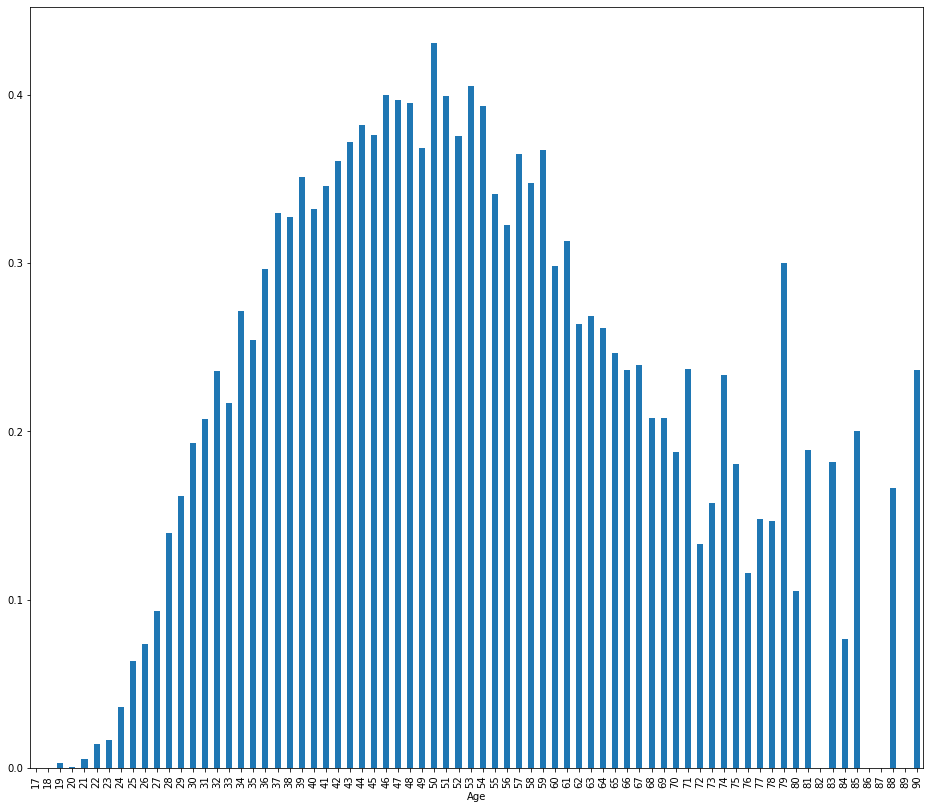

In [16]:
data_.groupby('Age').IncomeBin.mean().plot(kind='bar', figsize=(16,14))

<AxesSubplot:xlabel='Education Years'>

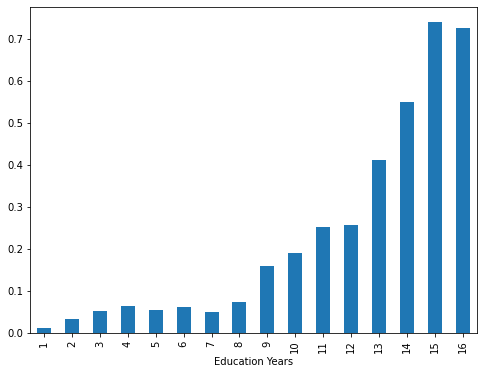

In [17]:
data_.groupby('Education Years').IncomeBin.mean().plot(kind='bar', figsize=(8,6))

<AxesSubplot:xlabel='Hours Per Week'>

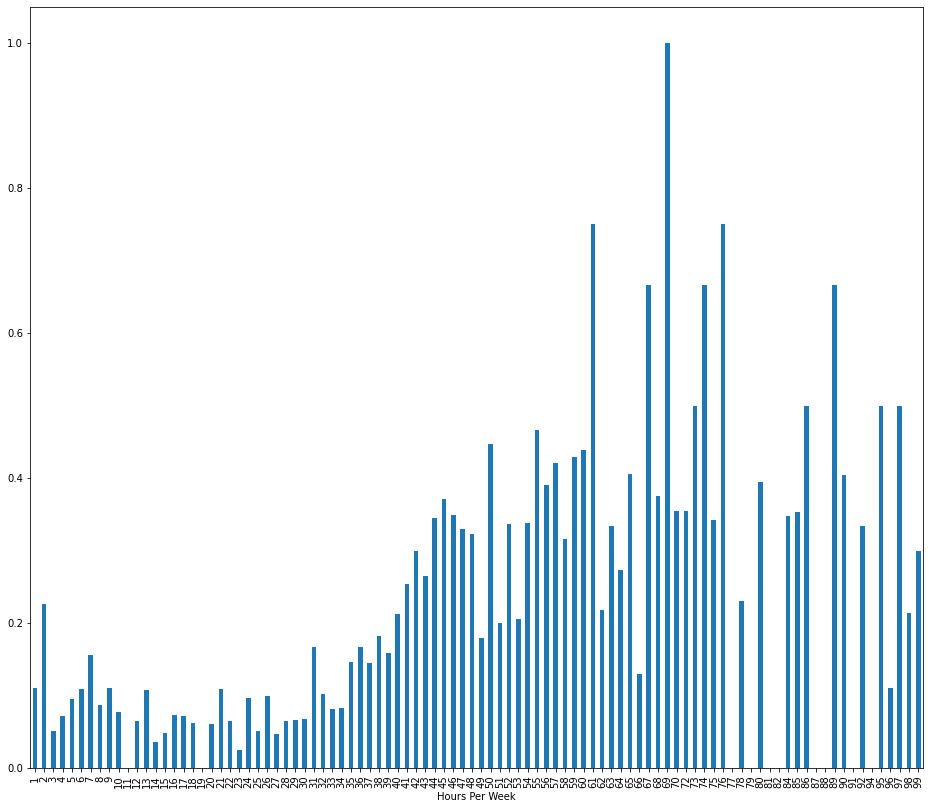

In [18]:
data_.groupby('Hours Per Week').IncomeBin.mean().plot(kind='bar', figsize=(16,14))

* Feature engineered column: Age Group -> Categorical representation of age group

In [20]:
ages = data_['Age']
min_age_dec = ages.min() - ages.min() % 10
max_age_dec = ages.max() + 10 - ages.max() % 10
age_ranges = list(range(min_age_dec, max_age_dec + 10, 10))
age_to_label = {}
for i in range(len(age_ranges) - 1):
    label = f'Age group {age_ranges[i]}-{age_ranges[i+1]}'
    for age in range(age_ranges[i], age_ranges[i+1]):
        age_to_label[age] = label

In [22]:
age_group_labels = []
for age in ages:
    label = age_to_label[age]
    age_group_labels.append(label)
    
data_['Age group'] = age_group_labels
data_

,Age,Workclass,Education Level,Education Years,Marital Status,Occupation,Relationship,Race,Sex,Hours Per Week,Native Country,IncomeGT50,IncomeBin,Age group
0,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K,0,Age group 50-60
1,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K,0,Age group 30-40
2,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K,0,Age group 50-60
3,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K,0,Age group 20-30
4,37,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States,<=50K,0,Age group 30-40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,36,United-States,<=50K,0,Age group 30-40
16277,64,Private,HS-grad,9,Widowed,Prof-specialty,Other-relative,Black,Male,40,United-States,<=50K,0,Age group 60-70
16278,38,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,50,United-States,<=50K,0,Age group 30-40
16279,44,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,40,United-States,<=50K,0,Age group 40-50


In [23]:
data_.drop(columns=['Age','IncomeBin'], axis=1)

,Workclass,Education Level,Education Years,Marital Status,Occupation,Relationship,Race,Sex,Hours Per Week,Native Country,IncomeGT50,Age group
0,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K,Age group 50-60
1,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K,Age group 30-40
2,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K,Age group 50-60
3,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K,Age group 20-30
4,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States,<=50K,Age group 30-40
...,...,...,...,...,...,...,...,...,...,...,...,...
16276,Private,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,36,United-States,<=50K,Age group 30-40
16277,Private,HS-grad,9,Widowed,Prof-specialty,Other-relative,Black,Male,40,United-States,<=50K,Age group 60-70
16278,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,50,United-States,<=50K,Age group 30-40
16279,Private,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,40,United-States,<=50K,Age group 40-50


#### Part 3: One-Hot Encoding
* Transform base data set which includes both numerical and categorical features to a data set which includes only numerical features via one hot encoding of these categorical features.

In [31]:
cat_data

['Workclass',
 'Education Level',
 'Marital Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Native Country',
 ' <=50K']

In [25]:
catDf = data_[[
 'Workclass',
 'Education Level',
 'Marital Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Native Country',
 'IncomeGT50',
 'Age group'
]]

catDf

,Workclass,Education Level,Marital Status,Occupation,Relationship,Race,Sex,Native Country,IncomeGT50,Age group
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K,Age group 50-60
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K,Age group 30-40
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K,Age group 50-60
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K,Age group 20-30
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States,<=50K,Age group 30-40
...,...,...,...,...,...,...,...,...,...,...
16276,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,United-States,<=50K,Age group 30-40
16277,Private,HS-grad,Widowed,Prof-specialty,Other-relative,Black,Male,United-States,<=50K,Age group 60-70
16278,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K,Age group 30-40
16279,Private,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,United-States,<=50K,Age group 40-50


In [26]:
oheDf = pd.get_dummies(catDf)

oheDf.shape

(48841, 110)

In [34]:
num_data

['Age',
 'Col',
 'Education Years',
 'Capital Gain',
 'Capital Loss',
 'Hours Per Week']

In [27]:
numDf = data_[[
 'Education Years',
 'Hours Per Week'
  ]]

frames = [numDf, oheDf]

num_data_ = pd.concat(frames, axis=1)

num_data_.columns

Index(['Education Years', 'Hours Per Week', 'Workclass_Federal-gov',
       'Workclass_Local-gov', 'Workclass_Never-worked', 'Workclass_Private',
       'Workclass_Self-emp-inc', 'Workclass_Self-emp-not-inc',
       'Workclass_State-gov', 'Workclass_Without-pay',
       ...
       'IncomeGT50_>50K', 'Age group_Age group 10-20',
       'Age group_Age group 20-30', 'Age group_Age group 30-40',
       'Age group_Age group 40-50', 'Age group_Age group 50-60',
       'Age group_Age group 60-70', 'Age group_Age group 70-80',
       'Age group_Age group 80-90', 'Age group_Age group 90-100'],
      dtype='object', length=112)

#### Part 4: KNN & Decision Tree Classifiers
* Using the k-nearest neighbors and decision tree classifiers, a model will be built to predict whether an adult will make more than 50 thousand dollars a year based on indvidual attributes.

#### **KNN**

Using 10.0 % of total dataset.

------- current hp = {'n_neighbors': 1, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 1, 'weights': 'distance'} -------
------- current hp = {'n_neighbors': 2, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 2, 'weights': 'distance'} -------
------- current hp = {'n_neighbors': 3, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 3, 'weights': 'distance'} -------
------- current hp = {'n_neighbors': 4, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 4, 'weights': 'distance'} -------
------- current hp = {'n_neighbors': 5, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 5, 'weights': 'distance'} -------
------- current hp = {'n_neighbors': 6, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 6, 'weights': 'distance'} -------
------- current hp = {'n_neighbors': 7, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 7, 'weights': '

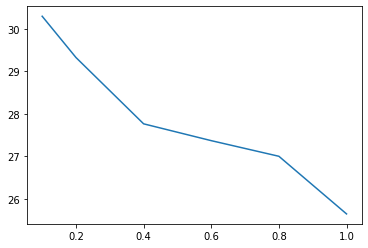

In [18]:
# Using our external custom module, we model a KNN and cross-validation on the adult dataset.
# We analyze the behavior and accuracy of the hyper-parameters we chose to consider

model_cls = KNeighborsClassifier
hyperparams = {'n_neighbors': K_VALUES, 'weights': ['uniform', 'distance']}
target_columns = ['IncomeGT50_<=50K', 'IncomeGT50_>50K']
test(model_cls, hyperparams, num_data_, target_columns)

#### **Decision Tree**

Using 10.0 % of total dataset.

------- current hp = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 2} -------
------- current hp = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 3} -------
------- current hp = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4} -------
------- current hp = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5} -------
------- current hp = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 6} -------
------- current hp = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 7} -------
------- current hp = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 8} -------
------- current hp = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 9} -------
------- current hp = {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2} -------
------- current hp = {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3} -------
------- current hp = {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4} -------
-----

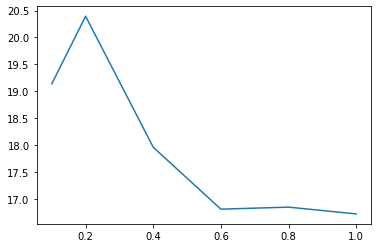

In [41]:
# Using our external custom module, we model a Decision Tree and cross-validation on the adult dataset.
# We analyze the behavior and accuracy of the hyper-parameters we chose to consider

model_cls = DecisionTreeClassifier
hyperparams = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': MAX_DEPTHS}
target_columns = ['IncomeGT50_<=50K', 'IncomeGT50_>50K']
test(model_cls, hyperparams, num_data_, target_columns)

## **Dataset 2: Mushrooms**

Link to dataset: https://archive.ics.uci.edu/ml/datasets/Mushroom

#### Part 1: Exploratory Data Analysis

In [21]:
# Import mushroom data from csv files

# Data set directories
mushroom_dataset_path = r'Mushrooms/mushrooms.csv'

# Mushroom data is not yet split into training/validation + test (one csv file at the moment)
data = pd.read_csv(mushroom_dataset_path)

data

,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE.1,TAPERING,BULBOUS,SMOOTH.1,SMOOTH.2,WHITE.2,WHITE.3,PARTIAL,WHITE.4,ONE,PENDANT,PURPLE,SEVERAL,WOODS
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,TAPERING,BULBOUS,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8411,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,ENLARGING,?,SMOOTH,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,ORANGE,SEVERAL,LEAVES
8412,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,ENLARGING,?,SMOOTH,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,ORANGE,CLUSTERED,LEAVES
8413,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,ENLARGING,?,SMOOTH,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,BUFF,SEVERAL,LEAVES
8414,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,ENLARGING,?,SMOOTH,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,BUFF,CLUSTERED,LEAVES


In [22]:
# Observe columns
data.columns

Index(['EDIBLE', 'CONVEX', 'SMOOTH', 'WHITE', 'BRUISES', 'ALMOND', 'FREE',
       'CROWDED', 'NARROW', 'WHITE.1', 'TAPERING', 'BULBOUS', 'SMOOTH.1',
       'SMOOTH.2', 'WHITE.2', 'WHITE.3', 'PARTIAL', 'WHITE.4', 'ONE',
       'PENDANT', 'PURPLE', 'SEVERAL', 'WOODS'],
      dtype='object')

In [23]:
# Renaming columns to appropriate names from the dataset description
data.rename(columns = {
    "EDIBLE": "Edible",
    "CONVEX": "Cap Shape",
    "SMOOTH": "Cap Surface",
    "WHITE": "Cap Color",
    "BRUISES": "Bruises",
    "ALMOND": "Odor",
    "FREE": "Gill Attachment",
    "CROWDED": "Gill Spacing",
    "NARROW": "Gill Size",
    "WHITE.1": "Gill Color",
    "TAPERING": "Stalk Shape",
    "BULBOUS": "Stalk Root",
    "SMOOTH.1": "Stalk Surface Above Ring",
    "SMOOTH.2": "Stalk Surface Below Ring",
    "WHITE.2": "Stalk Color Above Ring",
    "WHITE.3": "Stalk Color Below Ring",
    "PARTIAL": "Veil Type",
    "WHITE.4": "Veil Color",
    "ONE": "Ring Number",
    "PENDANT": "Ring Type",
    "PURPLE": "Spore Print Color",
    "SEVERAL": "Population",
    "WOODS": "Habitat"
}, inplace=True)

data.columns

Index(['Edible', 'Cap Shape', 'Cap Surface', 'Cap Color', 'Bruises', 'Odor',
       'Gill Attachment', 'Gill Spacing', 'Gill Size', 'Gill Color',
       'Stalk Shape', 'Stalk Root', 'Stalk Surface Above Ring',
       'Stalk Surface Below Ring', 'Stalk Color Above Ring',
       'Stalk Color Below Ring', 'Veil Type', 'Veil Color', 'Ring Number',
       'Ring Type', 'Spore Print Color', 'Population', 'Habitat'],
      dtype='object')

In [24]:
# Show shape of dataset
print("Dataset has shape:", data.shape)

Dataset has shape: (8416, 23)


In [25]:
# Describe data
data.describe().T

,count,unique,top,freq
Edible,8416,3,EDIBLE,4487
Cap Shape,8415,6,CONVEX,3795
Cap Surface,8415,4,SCALY,3268
Cap Color,8415,10,BROWN,2320
Bruises,8415,2,NO,5040
Odor,8415,9,NONE,3808
Gill Attachment,8415,2,FREE,8199
Gill Spacing,8415,2,CLOSE,6824
Gill Size,8415,2,BROAD,5880
Gill Color,8415,12,BUFF,1728


In [26]:
# Understanding numerical and categorical feature counts
num_data = [c for c in data.columns if data[c].dtype != 'O']
cat_data = [w for w in data.columns if data[w].dtype == 'O']

print("Numerical Feature count:", len(num_data))
print("Categorical Feature count:", len(cat_data))

Numerical Feature count: 0
Categorical Feature count: 23


In [27]:
# from the results above, we see that this dataset contains exclusively categorical features

In [28]:
# Check for null/empty values in data, show fraction of null values per feature
null_counter = data.isna().sum().sort_values(ascending=False)/len(data)

null_counter

Habitat                     0.000119
Stalk Shape                 0.000119
Cap Shape                   0.000119
Cap Surface                 0.000119
Cap Color                   0.000119
Bruises                     0.000119
Odor                        0.000119
Gill Attachment             0.000119
Gill Spacing                0.000119
Gill Size                   0.000119
Gill Color                  0.000119
Stalk Root                  0.000119
Population                  0.000119
Stalk Surface Above Ring    0.000119
Stalk Surface Below Ring    0.000119
Stalk Color Above Ring      0.000119
Stalk Color Below Ring      0.000119
Veil Type                   0.000119
Veil Color                  0.000119
Ring Number                 0.000119
Ring Type                   0.000119
Spore Print Color           0.000119
Edible                      0.000000
dtype: float64

In [29]:
# Since the number of null values in each feature is very small and seems to be consistent across columns, 
# we will safely drop the null values

In [30]:
# Remove rows with null/empty/Na values
print("Previous dataset shape:", data.shape)
data = data.dropna()
print("Resulting shape of dataset:", data.shape)

Previous dataset shape: (8416, 23)
Resulting shape of dataset: (8415, 23)


In [31]:
# Check what are the possible values for each columns
for col in data.columns:
  print("Column:", col)
  print(data[col].unique())

Column: Edible
['EDIBLE' 'POISONOUS']
Column: Cap Shape
['CONVEX' 'FLAT' 'BELL' 'SUNKEN' 'KNOBBED' 'CONICAL']
Column: Cap Surface
['SMOOTH' 'FIBROUS' 'SCALY' 'GROOVES']
Column: Cap Color
['WHITE' 'YELLOW' 'BROWN' 'GRAY' 'RED' 'PINK' 'PURPLE' 'GREEN' 'BUFF'
 'CINNAMON']
Column: Bruises
['BRUISES' 'NO']
Column: Odor
['ALMOND' 'ANISE' 'NONE' 'PUNGENT' 'CREOSOTE' 'FOUL' 'FISHY' 'SPICY'
 'MUSTY']
Column: Gill Attachment
['FREE' 'ATTACHED']
Column: Gill Spacing
['CROWDED' 'CLOSE']
Column: Gill Size
['NARROW' 'BROAD']
Column: Gill Color
['WHITE' 'PINK' 'BROWN' 'GRAY' 'BLACK' 'CHOCOLATE' 'PURPLE' 'GREEN' 'RED'
 'BUFF' 'YELLOW' 'ORANGE']
Column: Stalk Shape
['TAPERING' 'ENLARGING']
Column: Stalk Root
['BULBOUS' 'CLUB' 'ROOTED' 'EQUAL' '?']
Column: Stalk Surface Above Ring
['SMOOTH' 'FIBROUS' 'SILKY' 'SCALY']
Column: Stalk Surface Below Ring
['SMOOTH' 'SCALY' 'FIBROUS' 'SILKY']
Column: Stalk Color Above Ring
['WHITE' 'PINK' 'GRAY' 'BUFF' 'BROWN' 'RED' 'CINNAMON' 'YELLOW' 'ORANGE']
Column: Stalk 

In [32]:
# From above, we notice only the 'Stalk Root' column has this possible "?" value (this is actually stated in the dataset description)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8415 entries, 0 to 8414
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Edible                    8415 non-null   object
 1   Cap Shape                 8415 non-null   object
 2   Cap Surface               8415 non-null   object
 3   Cap Color                 8415 non-null   object
 4   Bruises                   8415 non-null   object
 5   Odor                      8415 non-null   object
 6   Gill Attachment           8415 non-null   object
 7   Gill Spacing              8415 non-null   object
 8   Gill Size                 8415 non-null   object
 9   Gill Color                8415 non-null   object
 10  Stalk Shape               8415 non-null   object
 11  Stalk Root                8415 non-null   object
 12  Stalk Surface Above Ring  8415 non-null   object
 13  Stalk Surface Below Ring  8415 non-null   object
 14  Stalk Color Above Ring  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matp

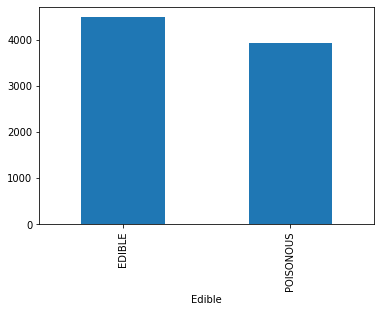

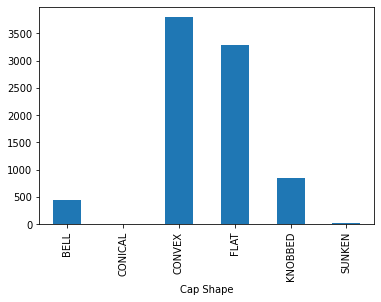

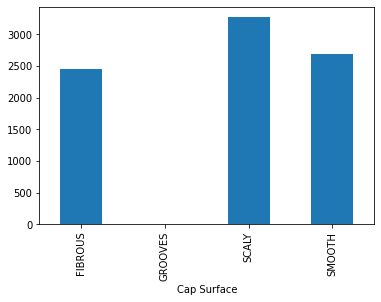

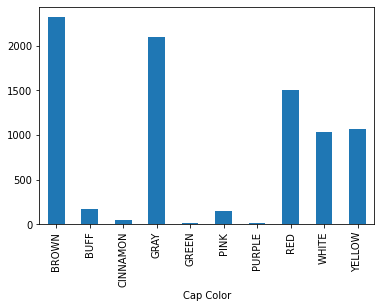

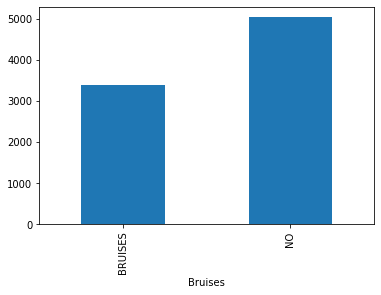

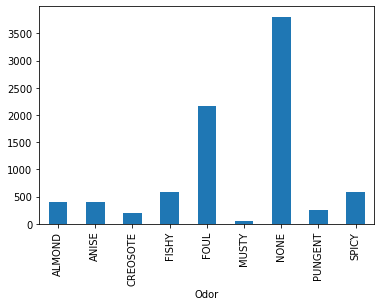

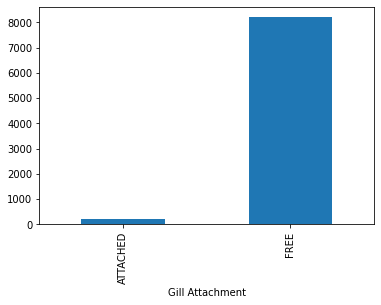

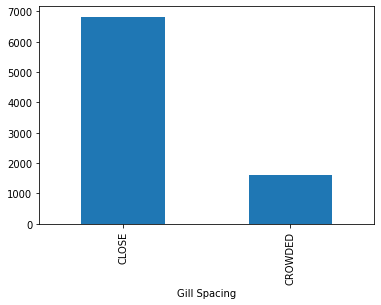

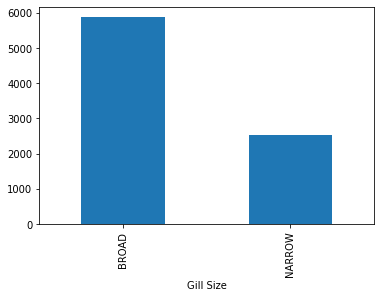

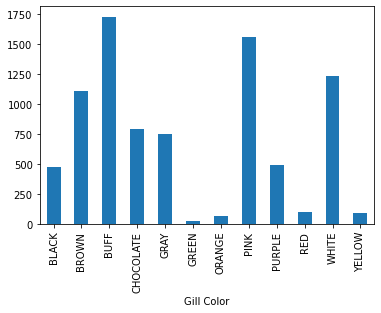

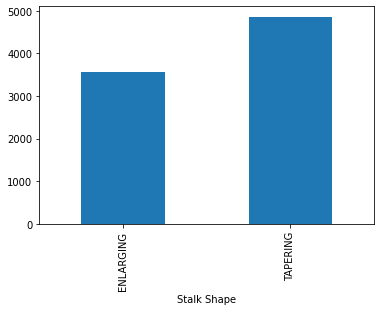

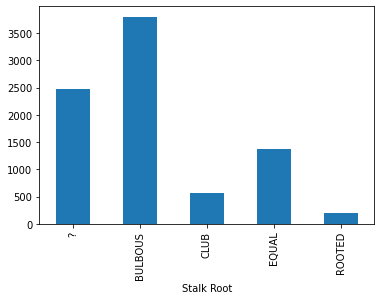

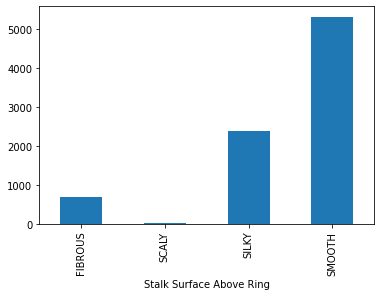

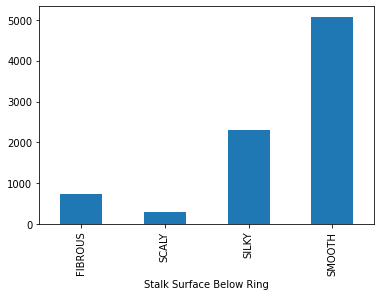

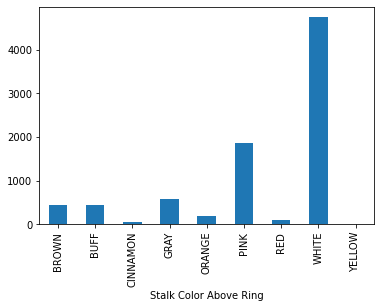

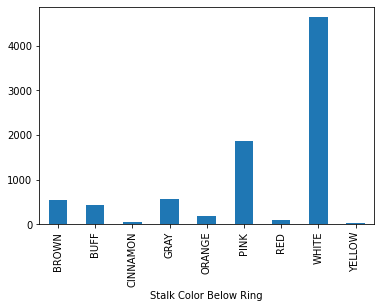

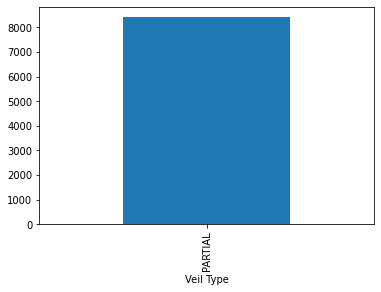

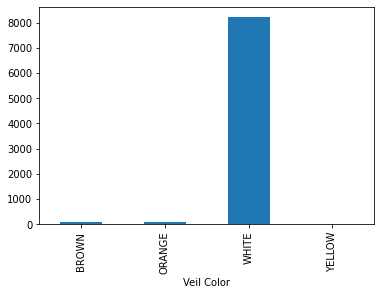

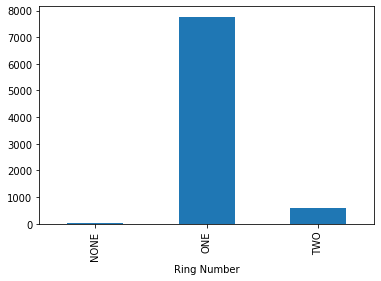

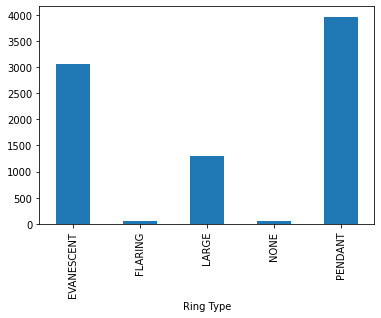

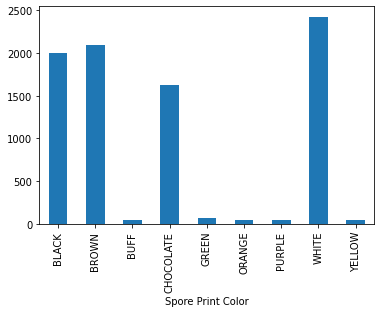

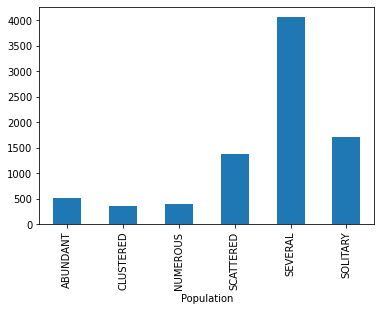

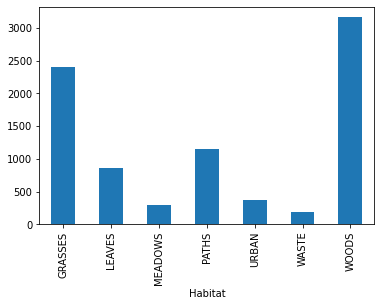

In [34]:
# Distribution plots for each column feature values
for col in data.columns:
    plt.figure()
    data.groupby(by=col).size().plot.bar()

In [35]:
# We notice for the "Stalk Root" feature, we have a large proportion of samples which hold a 
# '?' value, we choose to drop this feature.
data = data.drop(['Stalk Root'], axis=1)
data

,Edible,Cap Shape,Cap Surface,Cap Color,Bruises,Odor,Gill Attachment,Gill Spacing,Gill Size,Gill Color,Stalk Shape,Stalk Surface Above Ring,Stalk Surface Below Ring,Stalk Color Above Ring,Stalk Color Below Ring,Veil Type,Veil Color,Ring Number,Ring Type,Spore Print Color,Population,Habitat
0,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,WHITE,TAPERING,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
1,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
2,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,PINK,TAPERING,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
3,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,TAPERING,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,PURPLE,SEVERAL,WOODS
4,EDIBLE,CONVEX,SMOOTH,WHITE,BRUISES,ALMOND,FREE,CROWDED,NARROW,BROWN,TAPERING,SMOOTH,SMOOTH,WHITE,WHITE,PARTIAL,WHITE,ONE,PENDANT,BROWN,SEVERAL,WOODS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8410,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,ENLARGING,SMOOTH,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,BROWN,CLUSTERED,LEAVES
8411,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,ENLARGING,SMOOTH,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,ORANGE,SEVERAL,LEAVES
8412,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,ENLARGING,SMOOTH,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,ORANGE,CLUSTERED,LEAVES
8413,EDIBLE,KNOBBED,SMOOTH,BROWN,NO,NONE,ATTACHED,CLOSE,BROAD,BROWN,ENLARGING,SMOOTH,SMOOTH,ORANGE,ORANGE,PARTIAL,BROWN,ONE,PENDANT,BUFF,SEVERAL,LEAVES


#### Part 2: One-Hot Encoding

In [36]:
# One-Hot encode our categorical features (for this dataset, we happen to only have categorical features)
# Hence, we can use the resulting one-hot encoded matrix as our dataset
ohe = OneHotEncoder(sparse=False)

ohe_arr = ohe.fit_transform(data)
ohe_df = pd.DataFrame(data=ohe_arr, columns=ohe.get_feature_names())

print("One-Hot encoded dataframe:", ohe_df.shape)
ohe_df

One-Hot encoded dataframe: (8415, 114)


,x0_EDIBLE,x0_POISONOUS,x1_BELL,x1_CONICAL,x1_CONVEX,x1_FLAT,x1_KNOBBED,x1_SUNKEN,x2_FIBROUS,x2_GROOVES,x2_SCALY,x2_SMOOTH,x3_BROWN,x3_BUFF,x3_CINNAMON,x3_GRAY,x3_GREEN,x3_PINK,x3_PURPLE,x3_RED,x3_WHITE,x3_YELLOW,x4_BRUISES,x4_NO,x5_ALMOND,x5_ANISE,x5_CREOSOTE,x5_FISHY,x5_FOUL,x5_MUSTY,x5_NONE,x5_PUNGENT,x5_SPICY,x6_ATTACHED,x6_FREE,x7_CLOSE,x7_CROWDED,x8_BROAD,x8_NARROW,x9_BLACK,...,x14_ORANGE,x14_PINK,x14_RED,x14_WHITE,x14_YELLOW,x15_PARTIAL,x16_BROWN,x16_ORANGE,x16_WHITE,x16_YELLOW,x17_NONE,x17_ONE,x17_TWO,x18_EVANESCENT,x18_FLARING,x18_LARGE,x18_NONE,x18_PENDANT,x19_BLACK,x19_BROWN,x19_BUFF,x19_CHOCOLATE,x19_GREEN,x19_ORANGE,x19_PURPLE,x19_WHITE,x19_YELLOW,x20_ABUNDANT,x20_CLUSTERED,x20_NUMEROUS,x20_SCATTERED,x20_SEVERAL,x20_SOLITARY,x21_GRASSES,x21_LEAVES,x21_MEADOWS,x21_PATHS,x21_URBAN,x21_WASTE,x21_WOODS
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8410,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8411,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8412,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8413,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0

In [37]:
# At this point, we have preprocessed our dataset, we have cleaned the data, explored the distribution of feature values
# and have one-hot encoded our categorical features.

#### **KNN**


Using 10.0 % of total dataset.

------- current hp = {'n_neighbors': 1, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 1, 'weights': 'distance'} -------
------- current hp = {'n_neighbors': 2, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 2, 'weights': 'distance'} -------
------- current hp = {'n_neighbors': 3, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 3, 'weights': 'distance'} -------
------- current hp = {'n_neighbors': 4, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 4, 'weights': 'distance'} -------
------- current hp = {'n_neighbors': 5, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 5, 'weights': 'distance'} -------
------- current hp = {'n_neighbors': 6, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 6, 'weights': 'distance'} -------
------- current hp = {'n_neighbors': 7, 'weights': 'uniform'} -------
------- current hp = {'n_neighbors': 7, 'weights': '

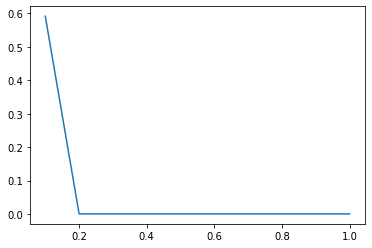

In [38]:
# Using our external custom module, we perform KNN and cross-validation on the mushrooms dataset.
# We analyze the behavior and accuracy of the hyper-parameters we chose to consider

model_cls = KNeighborsClassifier
hyperparams = {'n_neighbors': K_VALUES, 'weights': ['uniform', 'distance']}
target_columns = ['x0_EDIBLE', 'x0_POISONOUS']
test(model_cls, hyperparams, ohe_df, target_columns)


#### **Decision Tree**

Using 10.0 % of total dataset.

------- current hp = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 3} -------
------- current hp = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4} -------
------- current hp = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5} -------
------- current hp = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 6} -------
------- current hp = {'criterion': 'gini', 'splitter': 'random', 'max_depth': 3} -------
------- current hp = {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4} -------
------- current hp = {'criterion': 'gini', 'splitter': 'random', 'max_depth': 5} -------
------- current hp = {'criterion': 'gini', 'splitter': 'random', 'max_depth': 6} -------
------- current hp = {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3} -------
------- current hp = {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 4} -------
------- current hp = {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5} --

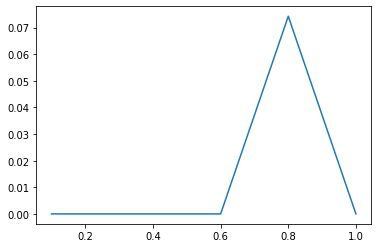

In [39]:
# Using our external custom module, we model a Decision Tree and cross-validation on the mushrooms dataset.
# We analyze the behavior and accuracy of the hyper-parameters we chose to consider

model_cls = DecisionTreeClassifier
hyperparams = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': MAX_DEPTHS}
target_columns = ['x0_EDIBLE', 'x0_POISONOUS']
test(model_cls, hyperparams, ohe_df, target_columns)